In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()

In [ ]:
df = pd.read_csv('/content/FakeNewsNet.csv')
df.head()

,title,news_url,source_domain,tweet_num,real
0,Kandi Burruss Explodes Over Rape Accusation on...,http://toofab.com/2017/05/08/real-housewives-a...,toofab.com,42,1
1,People's Choice Awards 2018: The best red carp...,https://www.today.com/style/see-people-s-choic...,www.today.com,0,1
2,Sophia Bush Sends Sweet Birthday Message to 'O...,https://www.etonline.com/news/220806_sophia_bu...,www.etonline.com,63,1
3,Colombian singer Maluma sparks rumours of inap...,https://www.dailymail.co.uk/news/article-33655...,www.dailymail.co.uk,20,1
4,Gossip Girl 10 Years Later: How Upper East Sid...,https://www.zerchoo.com/entertainment/gossip-g...,www.zerchoo.com,38,1


In [ ]:
df = df.dropna()

In [ ]:
df['real'].value_counts()

1    17371
0     5495
Name: real, dtype: int64

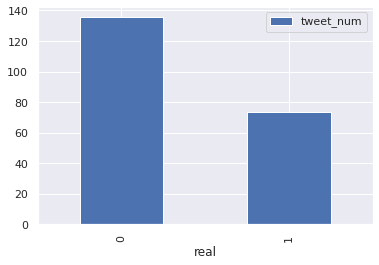

In [ ]:
df.groupby('real').mean().plot.bar()

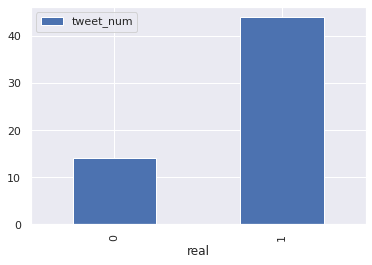

In [ ]:
df.groupby('real').median().plot.bar()

Фейковые новости в среднем более популярны.

In [ ]:
df['source_domain'].value_counts()

people.com                1786
www.dailymail.co.uk        964
en.wikipedia.org           741
www.usmagazine.com         709
www.etonline.com           666
                          ... 
bioguide.congress.gov        1
dailyheadlines.net           1
www.duggarfamily.com         1
www.naturallycurly.com       1
flashnewscorner.com          1
Name: source_domain, Length: 2441, dtype: int64

Наиболее популярные источники новостей:

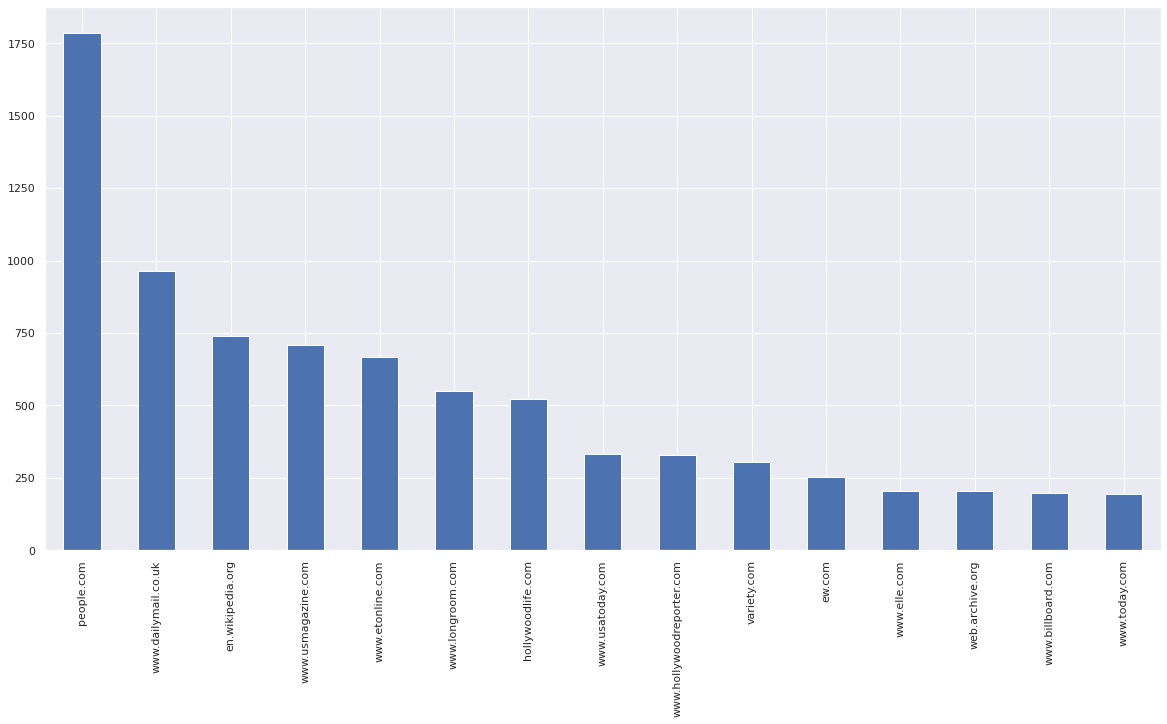

In [ ]:
df['source_domain'].value_counts()[:15].plot.bar(figsize=(20, 10));

Наиболее популярные источники реальных новостей:

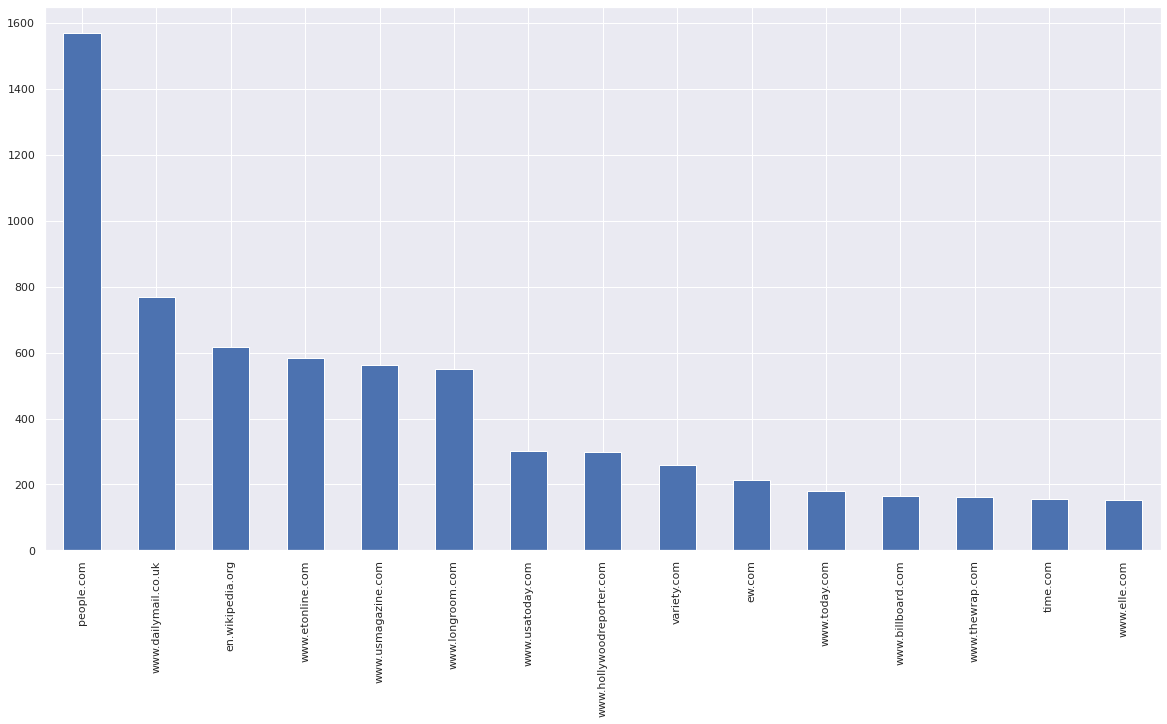

In [ ]:
df.loc[df['real'] == 1]['source_domain'].value_counts()[:15].plot.bar(figsize=(20, 10));

Наиболее популярные источники фейковых новостей:

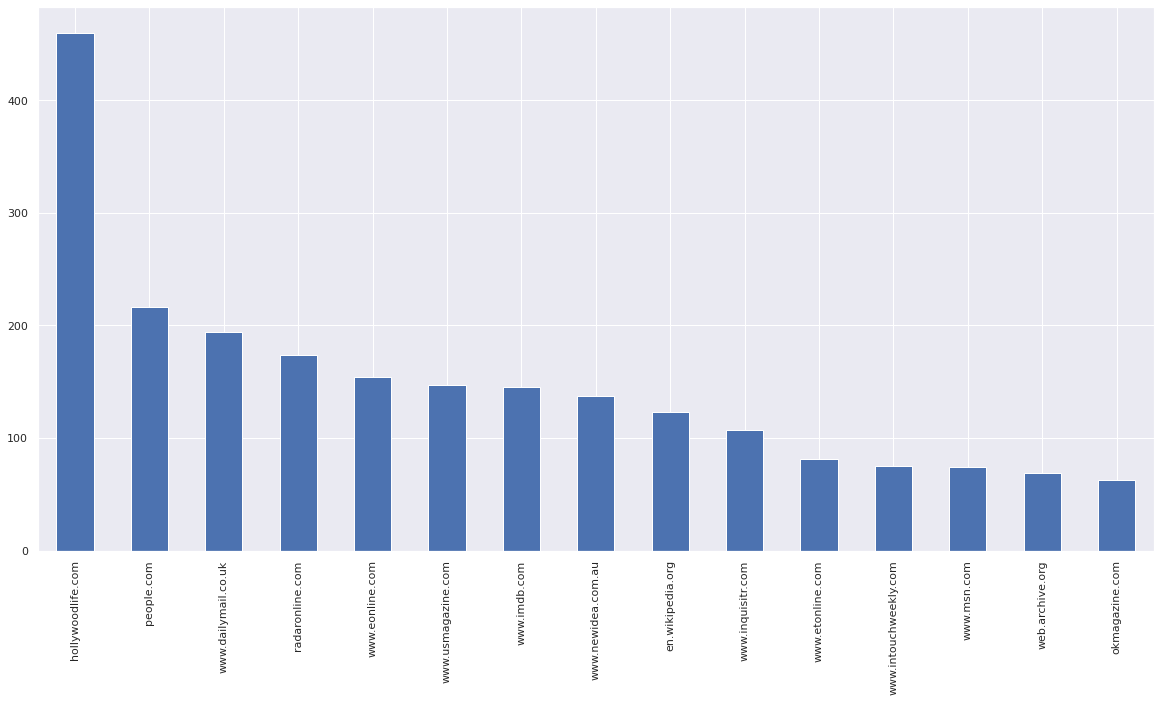

In [ ]:
df.loc[df['real'] == 0]['source_domain'].value_counts()[:15].plot.bar(figsize=(20, 10));

Зависимость количества ретвитов от реальности новости:

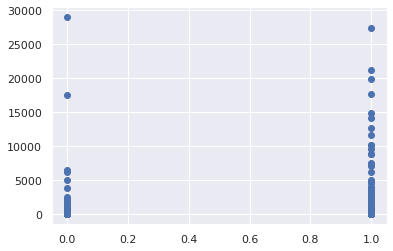

In [ ]:
plt.scatter(df['real'], df['tweet_num'])

In [ ]:
from sklearn import preprocessing

le = preprocessing.LabelEncoder()
le.fit(df['source_domain'])
df['source_domain'] = le.transform(df['source_domain'])
df.head()

,title,news_url,source_domain,tweet_num,real
0,Kandi Burruss Explodes Over Rape Accusation on...,http://toofab.com/2017/05/08/real-housewives-a...,972,42,1
1,People's Choice Awards 2018: The best red carp...,https://www.today.com/style/see-people-s-choic...,2259,0,1
2,Sophia Bush Sends Sweet Birthday Message to 'O...,https://www.etonline.com/news/220806_sophia_bu...,1435,63,1
3,Colombian singer Maluma sparks rumours of inap...,https://www.dailymail.co.uk/news/article-33655...,1354,20,1
4,Gossip Girl 10 Years Later: How Upper East Sid...,https://www.zerchoo.com/entertainment/gossip-g...,2419,38,1


Зависимость количества ретвитов от источника:

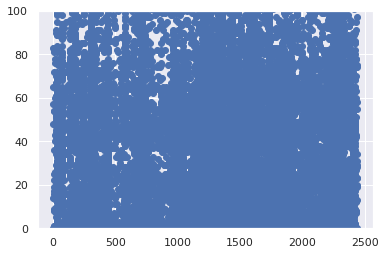

In [ ]:
plt.ylim(0, 100)
plt.scatter(df['source_domain'], df['tweet_num'])

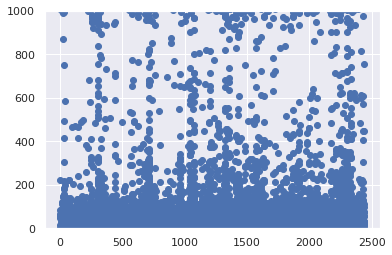

In [ ]:
plt.ylim(0, 1000)
plt.scatter(df['source_domain'], df['tweet_num'])

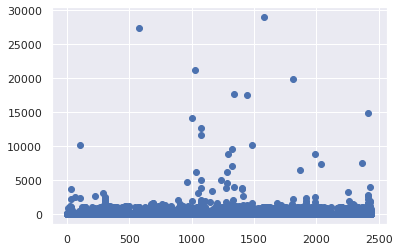

In [ ]:
plt.scatter(df['source_domain'], df['tweet_num'])

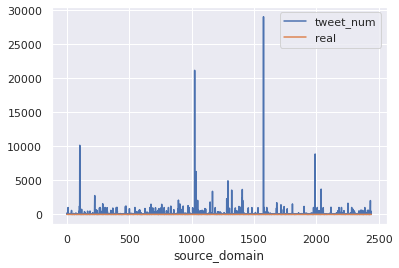

In [ ]:
df.groupby('source_domain').median().plot()

In [ ]:
df.corr()

,source_domain,tweet_num,real
source_domain,1.000000,-0.005761,0.013227
tweet_num,-0.005761,1.000000,-0.054292
real,0.013227,-0.054292,1.000000


# NLP

In [ ]:
import torch

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.8 MB 13.0 MB/s 
     |████████████████████████████████| 182 kB 21.9 MB/s 
     |████████████████████████████████| 7.6 MB 53.6 MB/s 


In [ ]:
import transformers as ppb 

In [ ]:
df = df[:2000] # из-за производительности используется не полный датасет

In [ ]:
df['real'].value_counts()

1    1537
0     463
Name: real, dtype: int64

In [ ]:
model_class, tokenizer_class, pretrained_weights = (ppb.DistilBertModel, ppb.DistilBertTokenizer, 'distilbert-base-uncased')

tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model = model_class.from_pretrained(pretrained_weights).to(device)

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
tokenized = df['title'].apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))

In [ ]:
max_len = 0
for i in tokenized.values:
    if len(i) > max_len:
        max_len = len(i)

padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized.values])

In [ ]:
attention_mask = np.where(padded != 0, 1, 0)
attention_mask.shape

(2000, 50)

In [ ]:
input_ids = torch.tensor(np.array(padded)).to(device)

with torch.no_grad():
    last_hidden_states = model(input_ids)

In [ ]:
features = last_hidden_states[0][:,0,:].cpu().numpy()

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(20) 
projected = pca.fit_transform(features)
print(features.shape)
print(projected.shape)

(2000, 768)
(2000, 20)


In [ ]:
result = pd.DataFrame(np.vstack((projected.T, df['real'].T, df['source_domain'].T, df['tweet_num'])).T)

In [ ]:
result

,0,1,2,3,4,5,6,7,8,9,...,13,14,15,16,17,18,19,20,21,22
0,0.631965,0.247948,0.072010,0.193906,0.152291,-0.344705,0.348657,-0.153356,0.478120,0.070510,...,-0.271802,0.664415,0.242730,0.123761,-0.245255,0.317863,-0.241870,1.0,972.0,42.0
1,1.436793,0.296166,0.955306,0.396754,1.116910,0.173399,-0.174559,0.728709,-0.172230,-0.432763,...,-0.179117,-0.541582,-0.154526,0.161372,-0.439939,0.273159,0.161538,1.0,2259.0,0.0
2,-1.122316,2.056421,0.017144,0.374378,-0.527778,-0.263275,-0.069701,0.263376,0.561727,0.345134,...,-0.512180,0.030474,-0.215516,-0.641137,0.144706,0.273303,-0.149291,1.0,1435.0,63.0
3,1.645403,-0.792350,-0.101922,0.040137,-0.593356,-0.630918,0.284773,-0.463856,-0.034782,-0.337376,...,-0.022047,0.277358,0.322224,0.193483,-0.039990,0.111544,0.083266,1.0,1354.0,20.0
4,-1.061977,1.881629,0.364412,-0.099303,-0.027501,0.512927,0.155344,0.239075,-0.405651,0.134574,...,0.166357,0.409701,0.439793,0.252143,0.366897,0.394935,-0.358549,1.0,2419.0,38.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,-0.009639,-0.612480,0.325125,-0.423385,-0.088259,-0.548452,-0.099817,-0.218914,-0.078131,-0.127867,...,-0.479036,-0.362774,0.425409,0.076741,0.170453,0.102502,-0.421182,1.0,686.0,276.0
1996,-2.587256,0.463970,-0.369873,-0.485900,0.659293,0.274711,-0.023094,-0.159457,-0.466136,0.034821,...,0.170835,-0.005357,0.130923,-0.171764,0.127788,-0.198026,0.105613,1.0,1851.0,0.0
1997,0.954096,0.829280,-0.108180,-0.237407,-0.346951,-0.365667,0.019636,0.051374,-0.192689,0.243060,...,0.120913,0.324912,-0.378559,0.203491,0.355125,-0.150331,0.117539,0.0,1354.0,23.0
1998,0.017810,0.889981,-0.189275,0.026686,-0.168969,-0.032541,-0.554724,0.161085,-0.283778,0.494708,...,0.229566,0.298470,-0.270303,0.220837,-0.279428,-0.034637,-0.220011,1.0,1232.0,79.0


In [ ]:
result.corr()

,0,1,2,3,4,5,6,7,8,9,...,13,14,15,16,17,18,19,20,21,22
0,1.000000e+00,-9.326016e-10,-1.243901e-08,-1.726720e-09,-5.481670e-09,-7.571119e-09,-5.713580e-09,3.234456e-09,-4.793322e-09,-1.250792e-09,...,1.943878e-09,2.218208e-09,8.143104e-10,4.064863e-09,-6.995198e-09,-6.638545e-09,1.252248e-09,-0.045856,-0.047440,-0.037451
1,-9.326016e-10,1.000000e+00,3.220079e-09,6.145562e-09,2.011379e-08,3.994108e-09,6.199112e-09,6.297107e-09,-2.148506e-09,-9.738278e-09,...,2.128218e-09,-1.233425e-09,-1.066329e-08,3.003006e-09,-1.290256e-08,1.209312e-08,8.098222e-09,0.011906,0.047919,-0.128625
2,-1.243901e-08,3.220079e-09,1.000000e+00,2.949372e-07,3.089454e-09,3.765861e-08,1.253112e-07,1.003080e-07,6.759217e-08,-6.529699e-08,...,1.020176e-07,8.458746e-08,-1.204802e-08,-5.435248e-08,1.394157e-08,-1.202595e-08,2.259559e-09,0.047196,-0.066086,0.025269
3,-1.726720e-09,6.145562e-09,2.949372e-07,1.000000e+00,7.708134e-08,-1.708157e-07,2.288473e-07,2.328530e-07,1.013287e-07,3.338092e-08,...,1.719185e-07,6.613108e-08,-2.909871e-08,-3.053044e-08,6.429728e-09,6.945114e-09,1.662092e-08,-0.046482,-0.042159,0.081987
4,-5.481670e-09,2.011379e-08,3.089454e-09,7.708134e-08,1.000000e+00,6.226561e-08,4.352749e-08,-2.725280e-07,2.990920e-07,-2.707275e-08,...,8.851615e-08,1.780213e-07,4.370541e-08,-4.875018e-08,5.371779e-08,-3.883938e-08,-2.034582e-08,0.134538,0.066462,-0.002386
5,-7.571119e-09,3.994108e-09,3.765861e-08,-1.708157e-07,6.226561e-08,1.000000e+00,-1.763795e-07,3.379542e-07,-3.297916e-07,1.655512e-08,...,-1.581579e-07,-6.261110e-08,5.373494e-08,1.453786e-08,2.506027e-08,-1.598295e-08,5.348981e-09,0.071368,-0.047875,0.021209
6,-5.713580e-09,6.199112e-09,1.253112e-07,2.288473e-07,4.352749e-08,-1.763795e-07,1.000000e+00,9.340596e-09,9.555963e-08,9.390037e-08,...,2.183205e-08,-1.326744e-08,1.398260e-08,-1.051186e-07,4.303641e-08,-2.996201e-08,-1.953975e-08,-0.096349,-0.002729,0.030481
7,3.234456e-09,6.297107e-09,1.003080e-07,2.328530e-07,-2.725280e-07,3.379542e-07,9.340596e-09,1.000000e+00,-5.798701e-08,-9.735039e-08,...,2.077450e-07,1.368867e-07,2.386521e-08,1.219850e-07,-4.850896e-08,3.025423e-08,4.362847e-08,0.091036,0.014038,0.010973
8,-4.793322e-09,-2.148506e-09,6.759217e-08,1.013287e-07,2.990920e-07,-3.297916e-07,9.555963e-08,-5.798701e-08,1.000000e+00,5.307992e-08,...,1.548178e-08,6.636636e-09,1.438647e-08,-1.049281e-07,1.806126e-08,-1.456599e-08,-7.361947e-08,0.115362,-0.060135,0.000561
9,-1.250792e-09,-9.738278e-09,-6.529699e-08,3.338092e-08,-2.707275e-08,1.655512e-08,9.390037e-08,-9.735039e-08,5.307992e-08,1.000000e+00,...,-5.141858e-08,6.365155e-08,3.458796e-08,-7.318717e-09,-3.907367e-08,5.083091e-08,-6.864071e-08,-0.016253,-0.026704,0.001402
